<br>

# <center> Qiana - Training


<br>

---

<br>


# List of Contents



*   [1. Initialization](#initialization)
*   [2. NLP - Text Processing](#nlp)
*   [3. Preprocessing](#preprocessing)
*   [4. Model Design](#model_design)
*   [5. Model Training](#model_training)
*   [6. Model Evaluaiton](#model_evaluaiton)
*   [7. Save Model](#save_model)
*   [8. Save Data](#save_data)


<br>


<br>

> Dataset is collected from [Kaggle](https://www.kaggle.com/datasets/elvinagammed/chatbots-intent-recognition-dataset).

<br>

<br>
<br>

<a name='initialization'></a>
# 1. Initialization

<br>

## 1.1. Colab Configuration

### 1.1.1. Mount Google Drive

In [ ]:
'''
    This is required if the code runs in Google Colab.
    - this code will mount Google Drive for Colab.
    - the code needs to run only once.
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>

### 1.1.2. Defining Root Directory

In [ ]:
# this directory will be used as Root Directory to read/write any file
rootDir = '/content/drive/MyDrive/_ML/Qiana/'

<br>

## 1.2. Import Libraries

In [ ]:
# importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
import json

<br>

## 1.3. Import DataSet

<br> 

> Reading JSON DataSet

In [ ]:
# reading JSON file
filePath = rootDir + '02. DataSet/intents.json'
with open(filePath,'r') as data: 
  dataset = json.load(data)

In [ ]:
# converting to Dictionary
dataset = dict(dataset)

dataset = dataset['intents']

<br>

> Defining Lists

In [ ]:
messages = []  # to store message
msgIntents = []  # to store intents of messages
intents = []  # to store intent

responses = {}  # to store responses for each intents

responseType = {}  # to store response type for each intents

<br>

> Extract Messages, Intents, Responses, Response Type from Data

In [ ]:
for item in dataset:
  intent = item['intent']
  texts = item['texts']
  res = item['reply']
  res_type = item['response_type']

  for text in texts:
    messages.append(text)
    msgIntents.append(intent)  

  if intent not in intents:
    intents.append(intent)

  responses[intent] = res 

  responseType[intent] = res_type    

In [ ]:
intents = sorted(intents)

<br>
<br>

<a name='nlp'></a>

# 2. NLP - Text Processing

<br>

## 2.1. Initializing NLTK

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<br>

## 2.2. Tokenization

In [ ]:
def _tokenize(words):
  from nltk.tokenize import sent_tokenize, word_tokenize

  _tokenized_words = []

  for word in words:
    word_token = word_tokenize(word)
    _tokenized_words.append(word_token)

  return _tokenized_words

<br>

## 2.3. Filtering Stop Words

In [ ]:
def _filter_stopword(word_list):
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words("english"))
  
  _filtered_words = []

  for words in word_list:
    tempList = []
    for word in words:
      if word.casefold() not in stop_words:
        tempList.append(word)
    _filtered_words.append(tempList)
  
  return _filtered_words

<br>

## 2.4. Stemming

In [ ]:
def _stem(word_list):
  from nltk.stem import PorterStemmer
  stemmer = PorterStemmer()

  _stemmed_words = []

  for words in word_list:
    tempList = [stemmer.stem(word) for word in words]
    _stemmed_words.append(tempList)

  return _stemmed_words

<br>

## 2.5. Parts of Speech Tagging 

In [ ]:
def _pos_tag(word_list):
  _pos_tagged_words = []

  for words in word_list:
    tagged_words = nltk.pos_tag(words)
    _pos_tagged_words.append(tagged_words)

  return _pos_tagged_words

<br>

## 2.6. Lemmatizing

In [ ]:
def _lemmatize(word_list):
  from nltk.corpus import wordnet
  def get_wordnet_pos(word):
      """Map POS tag to first character lemmatize() accepts"""
      
      tag = nltk.pos_tag([word])[0][1][0].lower()
      
      tag_dict = {"a": wordnet.ADJ,
                  "n": wordnet.NOUN,
                  "v": wordnet.VERB,
                  "r": wordnet.ADV}
      
      return tag_dict.get(tag, wordnet.NOUN)

  from nltk.stem import WordNetLemmatizer
  lemmatizer = WordNetLemmatizer()

  _lemmatized_words = []

  for words in word_list:
    tempList = []
    
    for word in words:
      pos = get_wordnet_pos(word)
      lemma = lemmatizer.lemmatize(word=word, pos=pos)
      tempList.append(lemma.lower())
    
    _lemmatized_words.append(tempList)

  return _lemmatized_words

<br>

## 2.7. Generate Bag of Words

In [ ]:
def _generate_bag_of_words(word_list):
  tempBag = []

  for words in word_list:
    tempBag.extend(words)

  tempBag = set(tempBag)

  _bag_of_words = list( tempBag )

  _bag_of_words = sorted(_bag_of_words)

  return _bag_of_words

<br>

## 2.8. Data Matrix Generator

In [ ]:
def matrix_generator(word_list):
  template_row = [0 for _ in range(0, len(bag_of_words))]

  data_matrix = []

  for words in word_list:
    mat_row = template_row[:]

    for word in words:
      if word in bag_of_words:
        word_index = bag_of_words.index(word)
        _count = words.count(word)
        mat_row[word_index] = _count
    
    data_matrix.append(mat_row)
  
  return data_matrix 

<br>

## 2.9. Targets Generator

In [ ]:
def generate_targets():
  targets = []

  for intent in msgIntents:
    index = intents.index(intent)
    targets.append(index)

  # coverting to Categorical
  from tensorflow.keras.utils import to_categorical
  targets = to_categorical(targets)

  return targets

<br>

## 2.10. Text Processing

In [ ]:
# tokenizing
tokenized_words = _tokenize(messages)

In [ ]:
# stemmimg
stemmed_words = _stem(tokenized_words)

In [ ]:
# pos tagging
pos_tagged_words = _pos_tag(tokenized_words)

In [ ]:
# lemmatizing
lemmatized_words = _lemmatize(tokenized_words)

In [ ]:
# generating bag of words
bag_of_words = _generate_bag_of_words(lemmatized_words)

In [ ]:
len(bag_of_words)

186

In [ ]:
# generating matrix
data_matrix = matrix_generator(lemmatized_words)

In [ ]:
# creating dataframe
df = pd.DataFrame(data=data_matrix, columns=bag_of_words)

In [ ]:
df.head()

,!,'m,'s,",",.,;,?,a,about,adios,...,what,which,who,why,with,witty,would,you,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# generating targets
targets = generate_targets()

<br>
<br>

<a name='preprocessing'></a>

# 3. Preprocessing

In [ ]:
# Train Test Split
X = df.values
y = targets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

<br>
<br>

<a name='model_design'></a>

# 4. Model Design

In [ ]:
# importing libraries for model design
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [ ]:
# checking the shape of the training data
X_train.shape

(334, 186)

<br>

## 4.1. Creating Model

In [1]:
# creating a Deep Neural Network

model = Sequential()

model.add( Dense(units=185, activation='tanh') )
model.add( Dropout(0.3) )

model.add( Dense(units=130, activation='tanh') )
model.add( Dropout(0.55) )

model.add( Dense(units=245, activation='tanh') )
model.add( Dropout(0.15) )

model.add( Dense(units=160, activation='tanh') )
model.add( Dropout(0.4) )

model.add( Dense(units=88, activation='tanh') )
model.add( Dropout(0.45) )

model.add( Dense(units=175, activation='tanh') )
model.add( Dropout(0.3) )

model.add( Dense(units=22, activation = 'softmax') )

NameError: ignored

<br>

## 4.2. Compiling The Model

In [ ]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer='Adam'
  )

<br>
<br>

<a name='model_training'></a>

# 5. Model Training

<br>

## 5.1. Defining Callback

In [ ]:
# importing early stopping callbacks from keras
from keras.callbacks import EarlyStopping

# defining early stopping
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    min_delta = 0.001, # minimium amount of change to count as an improvement
    verbose = 1, 
    patience = 20,
    restore_best_weights = True, 
  )

<br>

## 5.2. Training The Model

In [ ]:
# training the Deep Neural Network

# model.fit(
#     x = X_train,
#     y = y_train ,
#     batch_size = 40,
#     epochs = 500,
#     validation_data = (X_test, y_test),
#     verbose = 0,
#     callbacks = [early_stop]
#   )

Epoch 1/500
9/9 [==============================] - 3s 95ms/step - loss: 3.0927 - accuracy: 0.0868 - val_loss: 2.5689 - val_accuracy: 0.3333
Epoch 2/500
9/9 [==============================] - 0s 24ms/step - loss: 2.6827 - accuracy: 0.2485 - val_loss: 2.1899 - val_accuracy: 0.3667
Epoch 3/500
9/9 [==============================] - 0s 25ms/step - loss: 2.3804 - accuracy: 0.3353 - val_loss: 1.8655 - val_accuracy: 0.5167
Epoch 4/500
9/9 [==============================] - 0s 28ms/step - loss: 2.0589 - accuracy: 0.4281 - val_loss: 1.5751 - val_accuracy: 0.6333
Epoch 5/500
9/9 [==============================] - 0s 23ms/step - loss: 1.8106 - accuracy: 0.5120 - val_loss: 1.3439 - val_accuracy: 0.6667
Epoch 6/500
9/9 [==============================] - 0s 25ms/step - loss: 1.5402 - accuracy: 0.5599 - val_loss: 1.1682 - val_accuracy: 0.6833
Epoch 7/500
9/9 [==============================] - 0s 28ms/step - loss: 1.3412 - accuracy: 0.6198 - val_loss: 1.0378 - val_accuracy: 0.7167
Epoch 8/500
9/9 [===

<br>
<br>

<a name='model_evaluaiton'></a>

# 6. Model Evaluaiton

<br>

## 6.1. Visualizing Loss Analysis

In [ ]:
# accessing history
model_loss = pd.DataFrame( model.history.history )

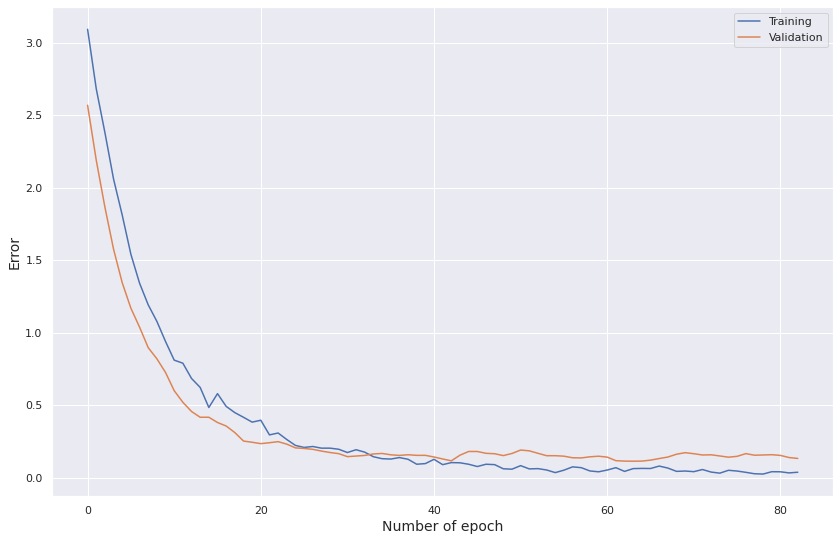

In [ ]:
# plotting the history
sns.set_theme(style="darkgrid")
# model_loss[['loss', 'val_loss']].plot(figsize=(14,9))
model_loss.columns = ['Training', 'accuracy', 'Validation', 'val_accuracy']
model_loss[['Training', 'Validation']].plot(figsize=(14,9))

# defining the label names for X-axis and Y-axis
plt.xlabel("Number of epoch", fontsize=14)
plt.ylabel("Error", fontsize=14)

# saving the plot
dpi = 1200
image_name = 'lossCurve_01'
image_save_path = f'{rootDir}03. Generated Data/Plots/{image_name}'
plt.savefig(image_save_path, dpi=dpi, pad_inches=0.2, bbox_inches='tight')

<br>

## 6.2. Classification Report and Confusion Matrix

<br>

#### Preparing Data

In [ ]:
# copying the original X and y test data
X_test_new = X_test
y_test_new = y_test

In [ ]:
def fill_missing_class() :
  '''
    This function will fill any Intent-Class missing in 'y_test'.
    The sklearn Train_Test_Split generates Train and Test data randomly. So any classes can be missed in the test data.
  '''

  # accessing the global numpy array to write
  global X_test_new
  global y_test_new

  # finding the classes in train and test data
  yTrainArgmax = set( y_train.argmax(axis=1) )
  yTestArgmax = set( y_test.argmax(axis=1) )

  # finding the intent classes missing in 'y_test' by comparing with 'y_train'
  missing_classes = yTrainArgmax.difference(yTestArgmax)
  
  # convering to List
  missing_classes = list(missing_classes)

  # iterating the missing classes 
  for mc in missing_classes:

    # finding the missing classes that exist in 'y_train'
    indices_mc = np.where(y_train.argmax(axis=1) == mc)[0]  # indices of any missing class

    # if any missing class has more then 5 entity then take first 5 otherwise take whatever entity the class has
    if len(indices_mc) > 4 :
      indices_mc = indices_mc[:5]

    # iteraring the indices, and appending intents from 'X_train' and 'y_train' using the indices
    for i in indices_mc:
      X_test_new = np.append(X_test_new, [X_train[i]], axis=0)
      y_test_new = np.append(y_test_new, [y_train[i]], axis=0)


In [ ]:
# filling any intents missing in 'y_test'
fill_missing_class()

<br>

#### Predicting on 'y_test' data

In [ ]:
# prediction on test set
predictions = model.predict(X_test_new)

3/3 [==============================] - 0s 6ms/step


In [ ]:
# finding the actual classes
y_test_argmax = y_test_new.argmax(axis=1)

# finding the predicted classes
predictions_argmax = predictions.argmax(axis=1)

<br>

### 6.2.1. Classification Report

In [ ]:
# importing the library
from sklearn.metrics import classification_report

# classification report
_CR = classification_report(y_test_argmax, predictions_argmax, target_names=intents)

# printing the report
print( _CR )

                          precision    recall  f1-score   support

                  Clever       1.00      0.50      0.67         2
CourtesyGreetingResponse       1.00      1.00      1.00         5
       CourtesyGreetings       1.00      1.00      1.00         1
            CustomerName       1.00      1.00      1.00         1
               FoodQuery       1.00      1.00      1.00         3
                 GoodBye       1.00      1.00      1.00         1
                  Gossip       1.00      1.00      1.00         3
               Greetings       1.00      1.00      1.00         2
          HumanNameQuery       1.00      1.00      1.00         1
                   Jokes       1.00      1.00      1.00         1
               MenuQuery       1.00      1.00      1.00         3
       MostSellingDishes       1.00      1.00      1.00         6
               NameQuery       1.00      1.00      1.00         4
              OfferQuery       1.00      1.00      1.00        11
         

<br>

### 6.2.2. Confusion Matrix

In [ ]:
# importing the library
from sklearn.metrics import confusion_matrix

# calculationg confusion matrix
confusionMat = confusion_matrix(y_test_argmax, predictions_argmax)

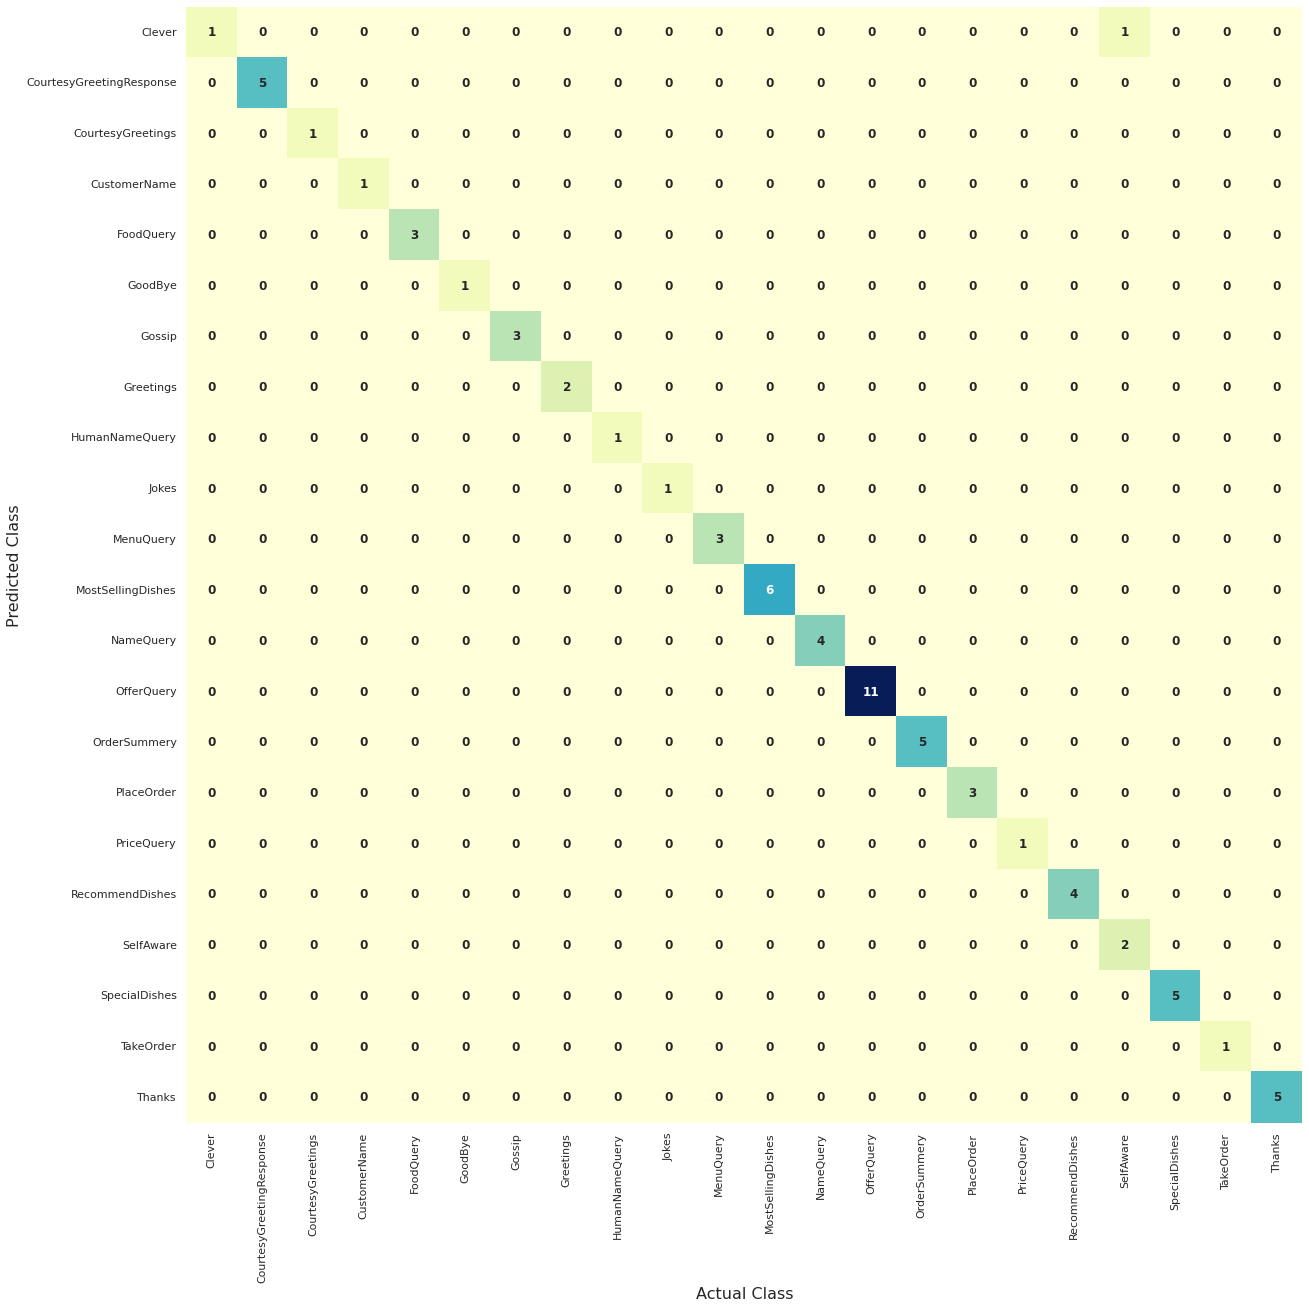

In [ ]:
# defining figure size
plt.figure(figsize=(20,22))

# plotting heatmap of confusion matrix
sns.heatmap(confusionMat, square=True, fmt='d', 
            cbar=False, cmap='YlGnBu',  
            xticklabels=intents,
            yticklabels=intents,
            annot=True,
            annot_kws={
                "fontsize":12,
                'fontweight': 'bold',
                },
          )

# defining the label names for X-axis and Y-axis
plt.xlabel('Actual Class', fontsize=16)
plt.ylabel('Predicted Class', fontsize=16)

# saving the plot
dpi = 1200
image_name = 'ConfusionMatrix_01'
image_save_path = f'{rootDir}/03. Generated Data/Plots/{image_name}'
plt.savefig(image_save_path, dpi=dpi, pad_inches=0.2, bbox_inches='tight')

<br>

## 6.3. Prediction on New Data

<br>

### 6.3.1. Creating Data

In [ ]:
# defining data position
pos = 112

# collecting data from dataframe - df
new_data = df.iloc[pos]

# reshaping the data
new_data = new_data.values.reshape(-1, 186)

# extracting true result
true_result_list = targets[pos]
true_class  = int( np.argmax(true_result_list) )

<br>

### 6.3.2. Predicting Class for Created Data

In [ ]:
# predicting result for new_data
predicted_class = model.predict(new_data)

# extracting the maximum predicted calss
predicted_class = int( np.argmax(predicted_class, axis=1) )

1/1 [==============================] - 0s 19ms/step


<br>

### 6.3.3. Extracting Class name

In [ ]:
# extracting predicted class name
predicted_class_name = intents[predicted_class]
print(f"\n The predicted class is : '{predicted_class_name}'")

# extracting actual class name
true_class_name = intents[true_class]
print(f"\n The actual class is : '{true_class_name}'")


 The predicted class is : 'HumanNameQuery'

 The actual class is : 'HumanNameQuery'


In [ ]:
customer = messages[pos]

resLength = len(responses[predicted_class_name])
resIndex = np.random.randint(resLength)
agent = responses[predicted_class_name]['responses'][resIndex]


print(f'Customer : {customer}')
print(f'Agent : {agent}')

Customer : Do you know my name?
Agent : You are <NAME>.


<br>
<br>

<a name='save_model'></a>

# 7. Save Model

In [ ]:
# defining the name of the model
modelName = 'Qiana.h5'

# creating the path
path = f"{rootDir}03. Generated Data/{modelName}"

# save model
model.save( filepath=path )

<br>
<br>

<a name='save_data'></a>

# 8. Save Intents, responses, response typer, bag_of_words

In [ ]:
fileName = 'data.json'
filePath = rootDir + '03. Generated Data/' + fileName

file_to_write = {
    'intents': intents,
    'responses': responses,
    'response_type': responseType,
    'bag_of_words' : bag_of_words
    }

# writing JSON file
with open(filePath,'w') as data: 
  data.write( json.dumps(file_to_write) )  # json.dumps() creates json in double quotes format